###### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2023 Semester 1

## Assignment 1: Music genre classification with naive Bayes


**Student ID(s):**     `1174154`


This iPython notebook is a template which you will use for your Assignment 1 submission.

Marking will be applied on the four functions that are defined in this notebook, and to your responses to the questions at the end of this notebook (Submitted in a separate PDF file).

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find.

**Adding proper comments to your code is MANDATORY. **

In [43]:
# run this as a start
import math
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

EPSILON = 0.00000001
BASE = -99999999

In [44]:
# This function should prepare the data by reading it from a file and converting it into a useful format for training and testing
def preprocess(filename):
    # test data classifying
    df = pd.read_csv(filename)

    X = df.iloc[:, 1:-1]
    y = df.iloc[:,-1]
    return X, y, df

In [45]:
# This function should calculate prior probabilities and likelihoods from the training data and using
# them to build a naive Bayes model

def train(X_train, y_train, train_data_df):
    #  X_test, y_test, test_data_df,  = preprocess()

    # calculate prior probability by getting unique labels and 
    prior_prob = {}

    unique_labels, counts = np.unique(y_train, return_counts=True)
    n = counts.sum()

    for i in range(len(unique_labels)):
        prior_prob[unique_labels[i]] = (counts[i] / n).round(3)

    # calculate miximum likelihood
    # gives attributes for the trainning dataset
    attribute_lists = X_train.columns
    likelihood_parameters = list()

    # for each label, correspond with a attribute, calculate the mean and sd for this combination, which will be used to calculate likelihoods P(attribute x1 | class ci)
    for label in unique_labels:
        data_with_label = train_data_df[train_data_df['label'] == label]

        for attribute in attribute_lists:
            train_attribute_mean = data_with_label[attribute].mean()
            train_attribute_std = data_with_label[attribute].std()
            likelihood_parameters.append([train_attribute_mean, train_attribute_std])
    return prior_prob, likelihood_parameters

In [46]:
# This function should predict classes for new items in a test dataset

def predict(prior_prob, likelihood_parameters, X_test):
    # get the labels and attributes for our test dataset
    unique_labels = list(prior_prob.keys())
    attribute_lists = X_test.columns

    choice_list = list()
    for index, row in X_test.iterrows():
        row_len = len(row)
        
        highest_posterior = BASE
        best_choice = None
        for i in range(len(unique_labels)):
            # take a label and find the prior probability for this label
            label = unique_labels[i]
            prior = prior_prob[label]

            # parameters for each attribute under this label
            correspoding_parameters = likelihood_parameters[int(i*row_len) : int((i+1)*row_len)]

            posterior = math.log(prior)
            for j in range(len(attribute_lists)):
                # attribute value and parameters for this attribute
                attribute = attribute_lists[j]
                parameters = correspoding_parameters[j]
                
                # find likelihood using values invoved
                value = row[attribute]
                mu = parameters[0]
                sd = parameters[1]
                max_likelihood = 1 / (sd * math.sqrt(2 * math.pi)) * math.exp(-((value-mu)**2) / (2*sd**2))
                
                # if the max_likelihood is zero, we can use smoothing to deal with it
                if (max_likelihood <= EPSILON):
                    posterior += math.log(1/(row_len+1))
                else:
                    posterior += math.log(max_likelihood)
            
            if (posterior > highest_posterior):
                highest_posterior = posterior
                best_choice = label
        
        choice_list.append(best_choice)
    return choice_list

In [47]:
# This function should evaliate the prediction performance by comparing your model’s class outputs to ground
# truth labels

def evaluate(choice_list, y_test):
    # returns the table between the actual and predicted sets
    num = len(np.unique(y_test))
    if (num > 2):
        accuracy = accuracy_score(y_test, choice_list)
        precision = precision_score(y_test, choice_list, average = "macro")
        recall = recall_score(y_test, choice_list, average = "macro")
        f1 = f1_score(y_test, choice_list, average = "macro")
    if (num == 2):
        accuracy = accuracy_score(y_test, choice_list)
        precision = precision_score(y_test, choice_list, pos_label="classical")
        recall = recall_score(y_test, choice_list, pos_label="classical")
        f1 = f1_score(y_test, choice_list, pos_label="classical")
    
    return accuracy, precision, recall, f1

In [48]:
# The following code is used to train the gztan files and get a cross table for the test dataset.

# train_file = 'COMP30027_2023_asst1_data\gztan_train.csv'
# test_file = 'COMP30027_2023_asst1_data\gztan_test.csv'

# X_train, y_train, train_data_df = preprocess(train_file)
# X_test, y_test, test_data_df = preprocess(test_file)

# prior_prob, likelihood_parameters = train(X_train, y_train, train_data_df)

# choice_list = predict(prior_prob, likelihood_parameters, X_test)

# table = evaluate(choice_list, y_test)

# print(table)


In [49]:
# this function is used to run all the four basic functions and return accuracy, precision, recall and f1 score, which are the evaluation results.
def run_all(train_file_name, test_file_name):
    X_train, y_train, train_data_df = preprocess(train_file_name)
    X_test, y_test, test_data_df = preprocess(test_file_name)

    prior_prob, likelihood_parameters = train(X_train, y_train, train_data_df)

    choice_list = predict(prior_prob, likelihood_parameters, X_test)

    accuracy, precision, recall, f1 = evaluate(choice_list, y_test)

    return accuracy, precision, recall, f1

## Task 1. Pop vs. classical music classification

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

### Q1
Compute and report the accuracy, precision, and recall of your model (treat "classical" as the "positive" class).

In [50]:
train_file = 'COMP30027_2023_asst1_data\pop_vs_classical_train.csv'
test_file = 'COMP30027_2023_asst1_data\pop_vs_classical_test.csv'

accuracy, precision, recall, f1 = run_all(train_file, test_file)

print("The accuracy is", accuracy)
print("The precision is", precision)
print("The recall is", recall)

The accuracy is 0.9767441860465116
The precision is 0.9523809523809523
The recall is 1.0


### Q2
For each of the features X below, plot the probability density functions P(X|Class = pop) and P(X|Class = classical). If you had to classify pop vs. classical music using just one of these three features, which feature would you use and why? Refer to your plots to support your answer.
- spectral centroid mean
- harmony mean
- tempo

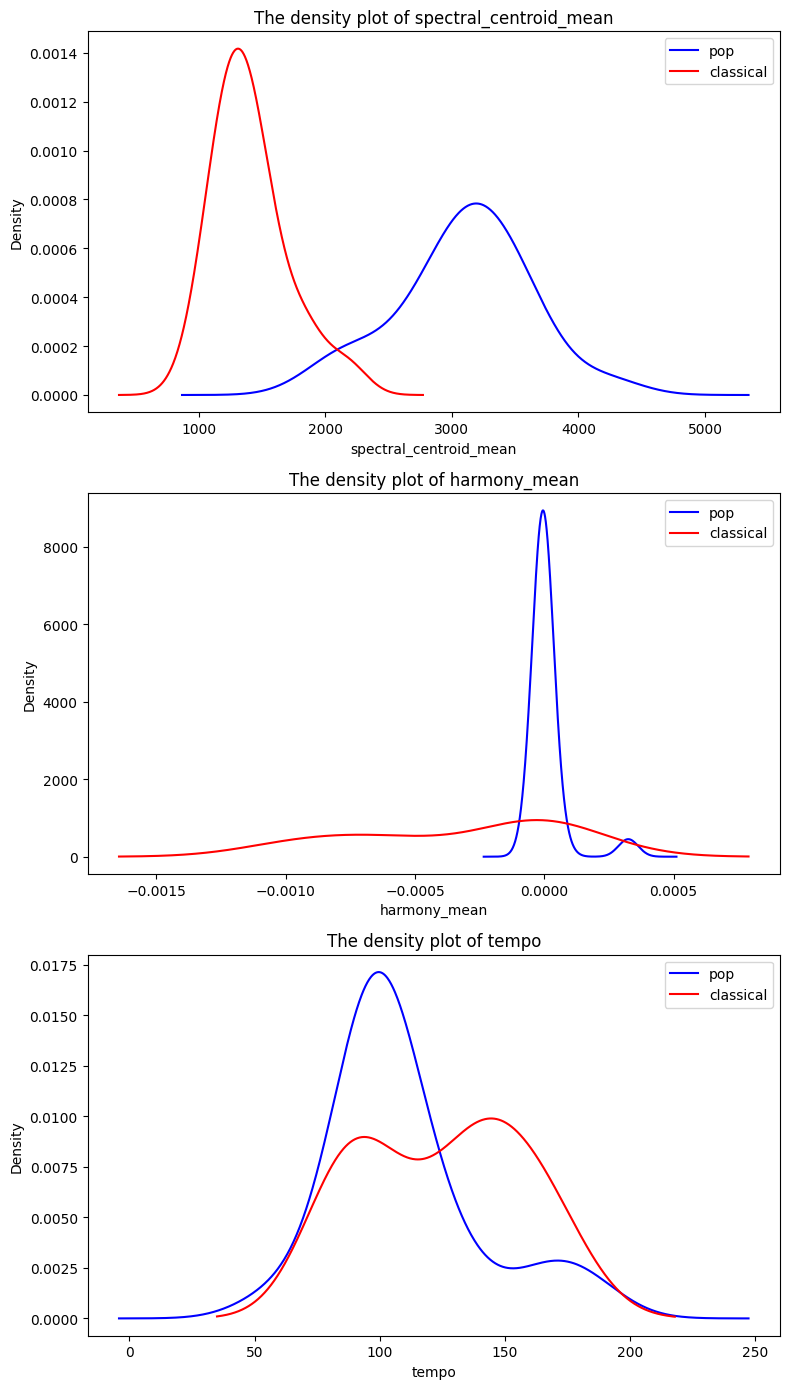

In [51]:
X_test, y_test, test_data_df = preprocess(test_file)

pop_data = test_data_df[test_data_df['label'] == 'pop']
classical_data = test_data_df[test_data_df['label'] == 'classical']

custom_lines = [Line2D([0], [0], color="blue"),
                Line2D([0], [0], color="red")]

plt.figure(figsize=(8,14))

# create a graph consists three sub density plots by using different attributes
plt.subplot(311).legend(custom_lines, ['pop', 'classical'])
pop_data.spectral_centroid_mean.plot.density(color='blue')
classical_data.spectral_centroid_mean.plot.density(color='red')
plt.xlabel("spectral_centroid_mean")
plt.title("The density plot of spectral_centroid_mean")

plt.subplot(312).legend(custom_lines, ['pop', 'classical'])
pop_data.harmony_mean.plot.density(color='blue')
classical_data.harmony_mean.plot.density(color='red')
plt.xlabel("harmony_mean")
plt.title("The density plot of harmony_mean")

plt.subplot(313).legend(custom_lines, ['pop', 'classical'])
pop_data.tempo.plot.density(color='blue')
classical_data.tempo.plot.density(color='red')
plt.xlabel("tempo")
plt.title("The density plot of tempo")

plt.tight_layout()

I may choose spectral_centroid_mean to be the attribute X. The reason to choose one of the three attributes is that we want one attribute to best distinguish two labels (pop and classical). We dont want some values of the attribute results into a difficulty for seperating two labels, that is to find the graph which has the minimum area of overlaps between the blue and red curves. By using visual approximation, we will certainly exclude the temp as it appreatly has a big overlapping, and the overlapping area of the spectral_centroid_mean is similar to a triangle (1000 * 0.0002 / 2 = 0.1) while the area of the harmony mean is roughly a rectangle (0.00025 * 1000 = 0.25). We would like to choose the one with the minimum area, that is spectral_centroid_mean.

## Task 2. 10-way music genre classification

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

### Q3
Compare the performance of the full model to a 0R baseline and a one-attribute baseline. The one-attribute baseline should be the best possible naive Bayes model which uses only a prior and a single attribute. In your write-up, explain how you implemented the 0R and one-attribute baselines.

### Q4
Train and test your model with a range of training set sizes by setting up your own train/test splits. With each split, use cross-fold validation so you can report the performance on the entire dataset (1000 items). You may use built-in functions to set up cross-validation splits. In your write-up, evaluate how model performance changes with training set size.

### Q5
Implement a kernel density estimate (KDE) naive Bayes model and compare its performance to your Gaussian naive Bayes model. You may use built-in functions and automatic ("rule of thumb") bandwidth selectors to compute the KDE probabilities, but you should implement the naive Bayes logic yourself. You should give the parameters of the KDE implementation (namely, what bandwidth(s) you used and how they were chosen) in your write-up.

### Q6
Modify your naive Bayes model to handle missing attributes in the test data. Recall from lecture that you can handle missing attributes at test by skipping the missing attributes and computing the posterior probability from the non-missing attributes. Randomly delete some attributes from the provided test set to test how robust your model is to missing data. In your write-up, evaluate how your model's performance changes as the amount of missing data increases.

In [52]:
# This function should predict classes for new items in a test dataset

def predict_missing_value(prior_prob, likelihood_parameters, X_test):
    # prior_prob, likelihood_parameters, X_test, y_test, test_data_df = train()

    # get the labels and attributes for our test dataset
    unique_labels = list(prior_prob.keys())
    attribute_lists = X_test.columns

    choice_list = list()
    for index, row in X_test.iterrows():
        row_len = len(row)
        
        highest_posterior = BASE
        best_choice = None
        for i in range(len(unique_labels)):
            # take a label and find the prior probability for this label
            label = unique_labels[i]
            prior = prior_prob[label]

            # parameters for each attribute under this label
            correspoding_parameters = likelihood_parameters[int(i*row_len) : int((i+1)*row_len)]

            posterior = math.log(prior)
            for j in range(len(attribute_lists)):
                # attribute value and parameters for this attribute
                attribute = attribute_lists[j]
                parameters = correspoding_parameters[j]
                
                # find likelihood using values invoved
                value = row[attribute]
                mu = parameters[0]
                sd = parameters[1]
                
                if not math.isnan(value):
                    max_likelihood = 1 / (sd * math.sqrt(2 * math.pi)) * math.exp(-((value-mu)**2) / (2*sd**2))
                    
                    # if the max_likelihood is zero, we can use smoothing to deal with it
                    if (max_likelihood <= EPSILON):
                        posterior += math.log(1/(row_len+1))
                    else:
                        posterior += math.log(max_likelihood)
            
            if (posterior > highest_posterior):
                highest_posterior = posterior
                best_choice = label
        
        choice_list.append(best_choice)
    return choice_list

In [53]:
def delete_value_by_proportion(test_data_df, proportion):
    df_copy = test_data_df.copy()
    for col in df_copy.columns[1:-1]:
        df_copy.loc[df_copy.sample(frac = proportion).index, col] = np.nan
    
    return df_copy

In [54]:
# this function is used to run all the four basic functions, but can deal with missing values and return accuracy, precision, recall and f1 score, which are the evaluation results.
def run_all_missing_value(train_file_name, test_file_name, proportion):
    X_train, y_train, train_data_df = preprocess(train_file_name)
    X_test, y_test, test_data_df = preprocess(test_file_name)

    prior_prob, likelihood_parameters = train(X_train, y_train, train_data_df)
    
    modefied_test = delete_value_by_proportion(test_data_df, proportion)
    modefied_X = modefied_test.iloc[:, 1:-1]

    choice_list = predict_missing_value(prior_prob, likelihood_parameters, modefied_X)

    accuracy, precision, recall, f1 = evaluate(choice_list, y_test)

    return accuracy, precision, recall, f1

In [55]:
train_file = 'COMP30027_2023_asst1_data\gztan_train.csv'
test_file = 'COMP30027_2023_asst1_data\gztan_test.csv'

# this give 20 random proportions from 0 to 1 and sorted from low to high
proportions = sorted(np.random.uniform(0,1,20))
results = list()

for proportion in proportions:
    accuracy, precision, recall, f1 = run_all_missing_value(train_file, test_file, proportion)
    result = [proportion, accuracy, precision, recall, f1]
    results.append(result)

result_df = pd.DataFrame(results, columns=['proportion', 'accuracy', 'precision', 'recall', 'f1'])
print(result_df)

    proportion  accuracy  precision    recall        f1
0     0.002267     0.495   0.549410  0.507981  0.486664
1     0.046999     0.485   0.522587  0.494997  0.476539
2     0.144751     0.505   0.542420  0.514590  0.493161
3     0.149905     0.480   0.509471  0.489130  0.464161
4     0.221679     0.485   0.508146  0.495504  0.464921
5     0.251731     0.470   0.497502  0.475518  0.454506
6     0.279620     0.475   0.537136  0.482486  0.465325
7     0.283048     0.465   0.514138  0.470571  0.447051
8     0.386894     0.490   0.553411  0.501624  0.482691
9     0.418184     0.450   0.477260  0.457926  0.435112
10    0.436943     0.480   0.518734  0.489491  0.457444
11    0.522788     0.455   0.490747  0.458007  0.442323
12    0.553060     0.400   0.418243  0.408220  0.384105
13    0.609025     0.390   0.386362  0.394725  0.366465
14    0.704515     0.425   0.467456  0.433093  0.406916
15    0.739461     0.390   0.403824  0.393768  0.358376
16    0.810234     0.380   0.411772  0.386007  0

Text(0, 0.5, 'Accuracy / Precison / Recall / F1')

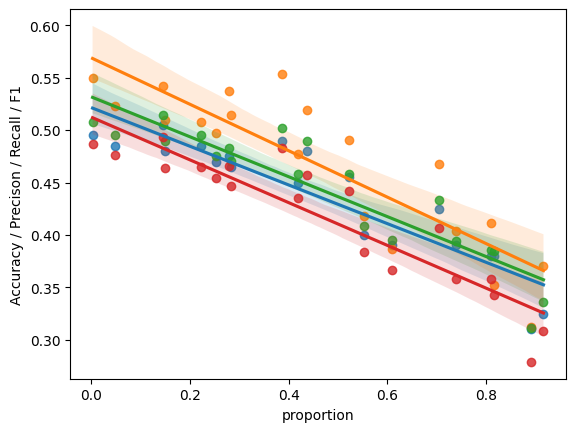

In [56]:
# plot the points and regression lines for accuracy, precision, recall and f1 on the same graph
sns.regplot(x = result_df['proportion'], y = result_df['accuracy'])
sns.regplot(x = result_df['proportion'], y = result_df['precision'])
sns.regplot(x = result_df['proportion'], y = result_df['recall'])
sns.regplot(x = result_df['proportion'], y = result_df['f1'])
plt.ylabel('Accuracy / Precison / Recall / F1')